<a href="https://colab.research.google.com/github/thisisindrajit/DRDetect/blob/main/Diabetic_Retinopathy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## References

- [Paper 1](https://ieeexplore.ieee.org/document/6139346)

- [Paper 2](https://iopscience.iop.org/article/10.1088/1757-899X/1070/1/012049)

- [Paper 3](https://www.sciencedirect.com/science/article/pii/S2352914820302069)
- 
[Paper 4](https://www.researchgate.net/publication/241634815_Detection_and_classification_of_diabetic_retinopathy_using_retinal_images)

- [Article](https://towardsdatascience.com/blindness-detection-diabetic-retinopathy-using-deep-learning-on-eye-retina-images-baf20fcf409e)

- [Sample code](https://github.com/debayanmitra1993-data/Blindness-Detection-Diabetic-Retinopathy-)

- [Link to DDR Dataset](https://drive.google.com/drive/folders/1z6tSFmxW_aNayUqVxx6h6bY4kwGzUTEC?usp=sharing)

- [Reference link for code 1](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/load_data/images.ipynb#scrollTo=Ea3kbMe-pGDw)

# Mounting Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Imports and initializations

In [2]:
import numpy as np
import pandas as pd
import imageio
import PIL #pillow
from PIL import Image
import cv2
import tensorflow as tf
import keras
import scipy
import os
import sys
import shutil
from collections import Counter
import matplotlib.pyplot as plt

from keras import models, layers, optimizers, regularizers
from keras.layers import Dense,Flatten,Conv2D,Activation,Dropout,Input,ZeroPadding2D
from keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model,Sequential
from keras.layers.convolutional import Conv2D
from keras.layers import MaxPooling2D
from keras import regularizers
from keras import optimizers
from keras.models import load_model
from keras import backend as K
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import cohen_kappa_score

# tf.config.experimental_run_functions_eagerly(True)

## Variables

In [3]:
dataset_dir = "/content/drive/MyDrive/Sem 7/Project/Dataset/APTOS-DDR-256/"
train_dir = dataset_dir + "train_images/"
valid_dir = dataset_dir + "valid_images/"

batch_size = 15
num_classes = 5

train_csv = pd.read_csv(dataset_dir + "train.csv")
valid_csv = pd.read_csv(dataset_dir + "valid.csv")

In [4]:
train_csv

,path,output
0,000c1434d8d7.png,2
1,001639a390f0.png,4
2,0024cdab0c1e.png,1
3,002c21358ce6.png,0
4,005b95c28852.png,0
...,...,...
3657,ffa47f6a7bf4.png,2
3658,ffc04fed30e6.png,0
3659,ffcf7b45f213.png,2
3660,ffd97f8cd5aa.png,0


In [6]:
train_csv.groupby("output").size()

output
0    1805
1     370
2     999
3     193
4     295
dtype: int64

In [ ]:
valid_csv

,path,output
0,20170323093705822.jpg,0
1,20170323093707381.jpg,0
2,20170323093821503.jpg,0
3,20170323093944125.jpg,0
4,20170323093945725.jpg,0
...,...,...
2498,007-6953-400.jpg,4
2499,007-6956-400.jpg,4
2500,007-6957-400.jpg,4
2501,007-6958-400.jpg,4


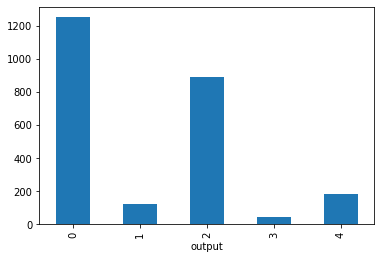

In [ ]:
valid_csv.groupby("output").size().plot(kind = "bar")

## Using Tensorflow with TPU

In [ ]:
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

# Modifying directories for easy processing by Keras

## Modifying Training directory

In [ ]:
# creating folders and arranging images based on target output
for i in range(len(train_csv)):
  file_name = train_csv["path"][i]
  output = train_csv["output"][i]

  original = train_dir + file_name
  target = train_dir + str(output) + '/' + file_name

  try:
    shutil.move(original,target)
  except:
    continue

## Modifying Validation directory

In [ ]:
# creating folders and arranging images based on target output
for i in range(len(valid_csv)):
  file_name = valid_csv["path"][i]
  output = valid_csv["output"][i]

  original = valid_dir + file_name
  target = valid_dir + str(output) + '/' + file_name

  try:
    shutil.move(original,target)
  except:
    continue

# Image pre-processing

In [ ]:
def crop_center(pil_img, crop_width, crop_height):
  img_width, img_height = pil_img.size
  return pil_img.crop(((img_width - crop_width) // 2,
                        (img_height - crop_height) // 2,
                        (img_width + crop_width) // 2,
                        (img_height + crop_height) // 2))

## Preprocessing training dataset

In [ ]:
for i in range(len(train_csv)):
  if (train_csv["output"][i] != 5): # 5 is ungradeable
    file_name = train_csv["path"][i]
    output = train_csv["output"][i]
    original_img = train_dir + str(output) + '/' + file_name

    img = cv2.imread(original_img)

    # converting to grayscale
    gray_img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # applying equalize histograms function
    gray_img_eqhist=cv2.equalizeHist(gray_img)

    # creating CLAHE filter and applying
    clahe=cv2.createCLAHE(clipLimit=10)
    gray_img_clahe=clahe.apply(gray_img_eqhist)

    kernel = np.array([[0, 0, 0],
                        [0, 1, 0],
                        [0, 0, 0]])

    # sharpening the image
    sharp = cv2.filter2D(src=gray_img_clahe, ddepth=-1, kernel=kernel)

    # inverting (negating) the image 
    invimage = cv2.bitwise_not(sharp)

    preprocessed_image = Image.fromarray(invimage)  

    target_path = train_dir + str(output) + '/' + file_name

    preprocessed_image.save(target_path)

## Preprocessing validation dataset

In [ ]:
for i in range(len(valid_csv)):
  if (valid_csv["output"][i] != 5): # 5 is ungradeable
    file_name = valid_csv["path"][i]
    output = valid_csv["output"][i]
    original_img = valid_dir + str(output) + '/' + file_name

    img = cv2.imread(original_img)

    # converting to grayscale
    gray_img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # equalizing all histograms
    gray_img_eqhist=cv2.equalizeHist(gray_img)

    # creating CLAHE filter and applying it to the equalized histogram image
    clahe=cv2.createCLAHE(clipLimit=10)
    gray_img_clahe=clahe.apply(gray_img_eqhist)

    kernel = np.array([[0, 0, 0],
                        [0, 1, 0],
                        [0, 0, 0]])

    # sharpening the image
    sharp = cv2.filter2D(src=gray_img_clahe, ddepth=-1, kernel=kernel)

    # inverting (negating) the image 
    invimage = cv2.bitwise_not(sharp)

    preprocessed_image = Image.fromarray(invimage)  

    target_path = valid_dir + str(output) + '/' + file_name

    preprocessed_image.save(target_path)

# Loading data using Keras utility

## Using ImageDataGenerator for data augmentation

In [ ]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

## Loading training and validation dataset

In [ ]:
train_generator = train_datagen.flow_from_directory(
        train_dir,
        # changing image size from 512*512 to 256*256
        target_size=(256, 256),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        valid_dir,
        # changing image size from 512*512 to 256*256
        target_size=(256, 256),
        batch_size=batch_size,
        class_mode='categorical')

Found 3648 images belonging to 5 classes.
Found 2503 images belonging to 5 classes.


In [ ]:
train_labels = train_generator.classes 
valid_labels = validation_generator.classes

In [ ]:
counter = Counter(train_generator.classes)

print(counter.items())

dict_items([(0, 1796), (1, 369), (2, 995), (3, 193), (4, 295)])


In [ ]:
counter = Counter(validation_generator.classes)

print(counter.items())

dict_items([(0, 1253), (1, 126), (2, 895), (3, 47), (4, 182)])


## Visualizing augmented data

In [ ]:
x,y = train_generator.next()

In [ ]:
from skimage import io

def imshow(image_RGB):
  io.imshow(image_RGB)
  io.show()

for i in range(0,11):
    image = x[i]
    imshow(image)

# Handling imbalanced data

## Generating weight class

In [ ]:
labels_count = dict()

# taking only labels from 0 to 4
for img_class in range(5):  
    labels_count[img_class] = len(train_csv[train_csv['output'] == img_class])

total_count = sum(labels_count.values())
class_weights = {cls: total_count / count for cls, count in 
                 enumerate(labels_count.values())}

print(class_weights)

{0: 1.998084902649218, 1: 19.873015873015873, 2: 2.7971403038427165, 3: 53.05084745762712, 4: 13.728070175438596}


# Training own model

In [ ]:
input = Input(shape=(256,256,3))

normalization_layer = tf.keras.layers.Rescaling(1./255)(input)

conv1 = Conv2D(16, kernel_size=(3,3), activation='relu', strides=(1, 1))(normalization_layer)
conv2 = Conv2D(16, kernel_size=(3,3), activation='relu', strides=(1, 1))(conv1)
bat1 = BatchNormalization()(conv2)
zero1 = ZeroPadding2D(padding=(1, 1))(bat1)

conv3 = Conv2D(32, kernel_size=(3,3), activation='relu', padding='valid', kernel_regularizer=regularizers.l2(0.05))(zero1)
conv4 = Conv2D(32, kernel_size=(3,3), activation='relu', padding='valid', kernel_regularizer=regularizers.l2(0.05))(conv3)
bat2 = BatchNormalization()(conv4)

conv5 = Conv2D(64, kernel_size=(3,3), activation='relu',strides=(1, 1), padding='valid')(bat2)
conv6 = Conv2D(64, kernel_size=(3,3), activation='relu',strides=(1, 1), padding='valid')(conv5)
bat3 = BatchNormalization()(conv6)
pool1 = MaxPooling2D(pool_size=(2, 2))(bat3)
zero2 = ZeroPadding2D(padding=(1, 1))(pool1)

conv7 = Conv2D(128, kernel_size=(3,3), activation='relu', padding='valid', kernel_regularizer=regularizers.l2(0.01))(zero2)
conv8 = Conv2D(128, kernel_size=(2,2), activation='relu', strides=(1, 1), padding='valid')(conv7)
bat4 = BatchNormalization()(conv8)

conv9 = Conv2D(64, kernel_size=(3,3), activation='relu', padding='valid', kernel_regularizer=regularizers.l2(0.02))(bat4)
conv10 = Conv2D(64, kernel_size=(3,3), activation='relu', padding='valid', kernel_regularizer=regularizers.l2(0.02))(conv9)
bat5 = BatchNormalization()(conv10)

conv11 = Conv2D(64, kernel_size=(3,3), activation='relu', strides=(1, 1))(bat5)
conv12 = Conv2D(64, kernel_size=(3,3), activation='relu', strides=(1, 1))(conv11)
bat6 = BatchNormalization()(conv12)
pool2 = MaxPooling2D(pool_size=(2, 2))(bat6)

conv13 = Conv2D(64, kernel_size=(3,3), activation='relu', padding='valid', kernel_regularizer=regularizers.l2(0.02))(pool2)
conv14 = Conv2D(64, kernel_size=(3,3), activation='relu', padding='valid', kernel_regularizer=regularizers.l2(0.02))(conv13)
bat7 = BatchNormalization()(conv14)

conv15 = Conv2D(128, kernel_size=(3,3), activation='relu', padding='valid', kernel_regularizer=regularizers.l2(0.05))(bat7)
conv16 = Conv2D(128, kernel_size=(2,2), activation='relu', strides=(1, 1), padding='valid')(conv15)
bat8 = BatchNormalization()(conv16)

flat = Flatten()(bat8)
hidden1 = Dense(32, activation='relu')(flat)
drop1 = Dropout(0.3)(hidden1)

hidden2 = Dense(32, activation='relu')(drop1)
drop2 = Dropout(0.2)(hidden2)

output = Dense(num_classes, activation='sigmoid')(drop2)

model = Model(inputs=input, outputs=output)

In [ ]:
learn_rate=.001
sgd=tf.keras.optimizers.SGD(learning_rate=learn_rate,momentum=.9,nesterov=False)
model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', 
                   mode='min', 
                   min_delta=0.001, 
                   verbose=1, 
                   patience=40, 
                   restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              mode='min', 
                              factor=0.9, 
                              patience=15, 
                              min_lr=1e-20, 
                              verbose=1, 
                              cooldown=3)

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 254, 254, 16)      448       
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 252, 252, 16)      2320      
_________________________________________________________________
batch_normalization_8 (Batch (None, 252, 252, 16)      64        
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 254, 254, 16)      0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 252, 252, 32)      4640

In [ ]:
with tf.device('/device:GPU:0'):
  history = model.fit(
        train_generator,
        epochs=15,
        validation_data=validation_generator,
        class_weight = class_weights,
        validation_steps=20, #50
        verbose=2,
        callbacks=[es, reduce_lr])

Epoch 1/15


In [ ]:
model.summary()

# Training Transfer Learning Model

## Getting the base model (Densenet)

In [ ]:
conv_base = tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

83697664/83683744 [==============================] - 1s 0us/step


## Creating the model

In [ ]:
model = models.Sequential()

model.add(conv_base)
model.add(layers.Flatten())

model.add(layers.Dense(1024,activation=('relu'),kernel_regularizer=regularizers.l2(0.003)))
model.add(layers.Dense(1024,activation=('relu'),kernel_regularizer=regularizers.l2(0.003)))
model.add(BatchNormalization())

model.add(layers.Dense(512,activation=('relu'),kernel_regularizer=regularizers.l2(0.003))) 
model.add(layers.Dense(512,activation=('relu'),kernel_regularizer=regularizers.l2(0.003)))
model.add(BatchNormalization())

model.add(layers.Dense(256,activation=('relu'))) 
model.add(layers.Dense(128,activation=('relu'))) 
model.add(layers.Dense(64,activation=('relu'))) 

model.add(layers.Dense(num_classes, activation='sigmoid'))

In [ ]:
print('Number of trainable weights before freezing the conv base:', len(model.trainable_weights))
conv_base.trainable = False
print('Number of trainable weights after freezing the conv base:', len(model.trainable_weights))

Number of trainable weights before freezing the conv base: 174
Number of trainable weights after freezing the conv base: 20


In [4]:
# custom loss function (Focal loss). Reference - https://towardsdatascience.com/handling-imbalanced-datasets-in-deep-learning-f48407a0e758

def focal_loss(y_true, y_pred):
  gamma = 2.0
  alpha = 0.25
  pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
  pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
  return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))

In [ ]:
learn_rate=.0001

#sgd=tf.keras.optimizers.SGD(learning_rate=learn_rate,momentum=.9,nesterov=False)
#rms = tf.keras.optimizers.RMSprop(learning_rate=2e-05)

adam = tf.keras.optimizers.Adam(learning_rate=learn_rate)

model.compile(optimizer=adam,
      loss=[focal_loss],
      metrics=["accuracy"])

es = EarlyStopping(monitor='val_loss', 
                   mode='min', 
                   min_delta=0.001, 
                   verbose=1, 
                   patience=40, 
                   restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              mode='min', 
                              factor=0.9, 
                              patience=15, 
                              min_lr=1e-20, 
                              verbose=1, 
                              cooldown=3)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 8, 8, 2048)        20861480  
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 1024)              134218752 
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
batch_normalization_4 (Batch (None, 1024)              4096      
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_3 (Dense)              (None, 512)               2

In [ ]:
with tf.device('/device:GPU:0'):
  history = model.fit(
        train_generator,
        epochs=30,
        validation_data=validation_generator,
        validation_steps=20,
        verbose=2,
        callbacks=[es, reduce_lr])

Epoch 1/30
244/244 - 1386s - loss: 15.3473 - accuracy: 0.5880 - val_loss: 17.4506 - val_accuracy: 0.5046
Epoch 2/30
244/244 - 115s - loss: 12.0512 - accuracy: 0.6828 - val_loss: 18.4679 - val_accuracy: 0.5090
Epoch 3/30
244/244 - 113s - loss: 10.7743 - accuracy: 0.7061 - val_loss: 15.4447 - val_accuracy: 0.5054
Epoch 4/30
244/244 - 114s - loss: 9.9407 - accuracy: 0.7152 - val_loss: 18.4006 - val_accuracy: 0.5126
Epoch 5/30
244/244 - 114s - loss: 9.3545 - accuracy: 0.7193 - val_loss: 17.9521 - val_accuracy: 0.5110
Epoch 6/30
244/244 - 113s - loss: 8.8558 - accuracy: 0.7355 - val_loss: 18.3942 - val_accuracy: 0.5166
Epoch 7/30
244/244 - 112s - loss: 8.4282 - accuracy: 0.7303 - val_loss: 22.9873 - val_accuracy: 0.5126
Epoch 8/30
244/244 - 114s - loss: 8.0608 - accuracy: 0.7434 - val_loss: 15.4669 - val_accuracy: 0.5290
Epoch 9/30
244/244 - 113s - loss: 7.7625 - accuracy: 0.7448 - val_loss: 14.3191 - val_accuracy: 0.5186
Epoch 10/30
244/244 - 113s - loss: 7.5360 - accuracy: 0.7423 - val_lo

In [ ]:
# model.save('./MyModel_tf',save_format='tf')

In [ ]:
# loading the saved model
# loaded_model = tf.keras.models.load_model('./MyModel_tf', custom_objects={'focal_loss': focal_loss})

In [ ]:
# retraining the model
# with tf.device('/device:GPU:0'):
#   history = loaded_model.fit(
#               train_generator,
#               epochs=15,
#               validation_data=validation_generator,
#               verbose=2,
#               callbacks=[es, reduce_lr])

## Plotting training and validation accuracy and loss

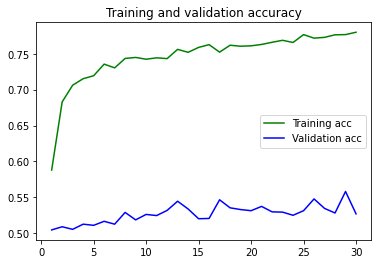

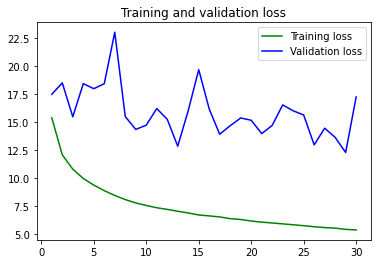

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', color='green', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', color='green', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Saving the model

In [ ]:
model.save("/content/drive/MyDrive/Sem 7/Project/models/2910_Xception_256*256_focalLoss_APTOSDDR.h5")

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


# Loading the trained model

In [7]:
load_model = keras.models.load_model("/content/drive/MyDrive/Sem 7/Project/models/2910_Xception_256*256_focalLoss_APTOSDDR.h5",  custom_objects={'focal_loss': focal_loss})

In [8]:
load_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 8, 8, 2048)        20861480  
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 1024)              134218752 
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
batch_normalization_4 (Batch (None, 1024)              4096      
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_3 (Dense)              (None, 512)               2

In [9]:
def crop_center(pil_img, crop_width, crop_height):
  img_width, img_height = pil_img.size
  return pil_img.crop(((img_width - crop_width) // 2,
                        (img_height - crop_height) // 2,
                        (img_width + crop_width) // 2,
                        (img_height + crop_height) // 2))
  
def expand2square(pil_img, background_color):
    width, height = pil_img.size
    if width == height:
        return pil_img
    elif width > height:
        result = Image.new(pil_img.mode, (width, width), background_color)
        result.paste(pil_img, (0, (width - height) // 2))
        return result
    else:
        result = Image.new(pil_img.mode, (height, height), background_color)
        result.paste(pil_img, ((height - width) // 2, 0))
        return result

def image_preprocessing(img_path):
    
    image = Image.open(img_path)

    if image.size[0] == image.size[1]:
      resized_image = image.resize((256,256))
    else:
      resized_image = crop_center(image,image.size[1],image.size[1]).resize((256,256))

    return np.asarray(resized_image)

In [10]:
valid_csv = pd.read_csv(dataset_dir + "valid.csv")

valid_csv

,path,output
0,20170323093705822.jpg,0
1,20170323093707381.jpg,0
2,20170323093821503.jpg,0
3,20170323093944125.jpg,0
4,20170323093945725.jpg,0
...,...,...
2498,007-6953-400.jpg,4
2499,007-6956-400.jpg,4
2500,007-6957-400.jpg,4
2501,007-6958-400.jpg,4


In [11]:
x_test = []
y_test = []

for i in range(len(valid_csv)):

  if valid_csv["output"][i] != 5:
    
    file_name = valid_csv["path"][i]
    output = valid_csv["output"][i]

    try:
      np_img = image_preprocessing(valid_dir + str(output) + '/' + file_name)
      expanded_img = np.expand_dims(np_img, axis=0)

      x_test.append(expanded_img)
      y_test.append(output)

    except:
      continue

In [13]:
y_pred_valid_set = []

for i in range(len(x_test)):
  y_pred = load_model.predict(x_test[i])
  y_pred_argmax = np.argmax(y_pred, axis=1)

  y_pred_valid_set.append(y_pred_argmax)

## Classification Report

In [14]:
print(classification_report(y_test, y_pred_valid_set))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67      1253
           1       0.00      0.00      0.00       126
           2       0.00      0.00      0.00       895
           3       0.00      0.00      0.00        47
           4       0.00      0.00      0.00       182

    accuracy                           0.50      2503
   macro avg       0.10      0.20      0.13      2503
weighted avg       0.25      0.50      0.33      2503



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Confusion Matrix

In [15]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, y_pred_valid_set, labels=[0, 1, 2, 3, 4]))

[[1253    0    0    0    0]
 [ 126    0    0    0    0]
 [ 895    0    0    0    0]
 [  47    0    0    0    0]
 [ 182    0    0    0    0]]


## ROC curves

ROC AUC score: 0.5044988913585992


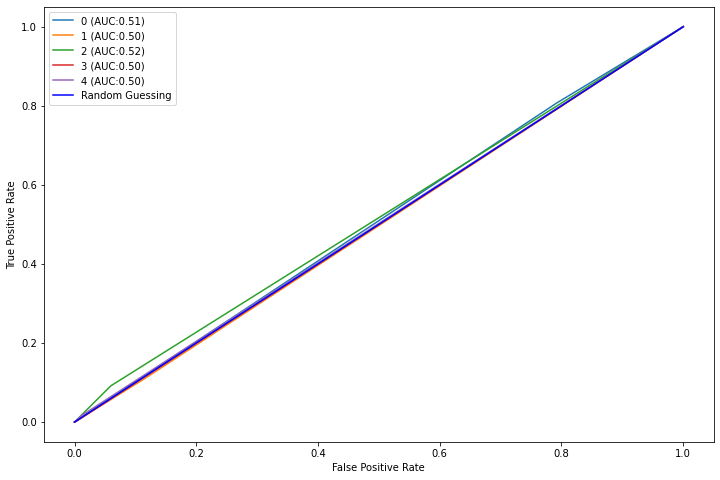

In [ ]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score


target= [0,1,2,3,4]

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)


print('ROC AUC score:', multiclass_roc_auc_score(y_test, y_pred_valid_set))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

## Precision Recall curves

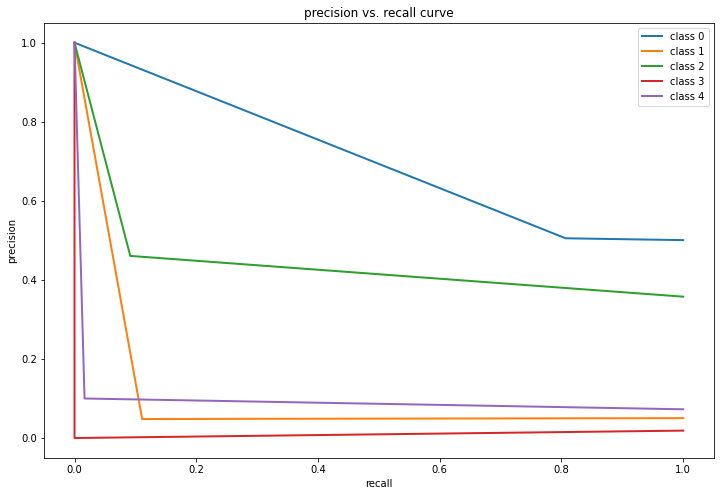

In [ ]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import precision_recall_curve


target= [0,1,2,3,4]

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

y_pred = y_pred_valid_set

lb = LabelBinarizer()
lb.fit(y_test)
y_test = lb.transform(y_test)
y_pred = lb.transform(y_pred)

n_classes = 5

precision = dict()
recall = dict()

for i in range(n_classes):
  precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                        y_pred[:, i])
  plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))
    
plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()

## Kappa Score

In [ ]:
cohen_kappa_score(y_test, y_pred_valid_set)

0.019543448178508283